In [127]:
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset
import os
import pandas as pd
from io import BytesIO
import base64
from openai import OpenAI
from sklearn.metrics import f1_score, roc_curve, auc, classification_report, precision_recall_fscore_support
import matplotlib.pyplot as plt
import numpy as np


client = OpenAI()
# Specify the path to your labels CSV file
labels_csv = r'C:\Users\H\Desktop\VC\test01.csv'
features = ["biomarker", "hydrodissection cannula", "rycroft cannula", "viscoelastic cannula", "capsulorhexis cystotome", "bonn forceps", "capsulorhexis forceps", "irrigation/aspiration handpiece", "phacoemulsifier handpiece", "implant injector", "primary incision knife", "secondary incision knife", "micromanipulator", "mendez ring"]

def encode_image(image_path, max_image=512):
    with Image.open(image_path) as img:
        width, height = img.size
        max_dim = max(width, height)
        if max_dim > max_image:
            scale_factor = max_image / max_dim
            new_width = int(width * scale_factor)
            new_height = int(height * scale_factor)
            img = img.resize((new_width, new_height))
        buffered = BytesIO()
        img.save(buffered, format="PNG")
        img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
        return img_str

class CustomDataset(Dataset):
    def __init__(self, data_dir, labels_csv):
        self.data_dir = data_dir
        self.image_files = os.listdir(data_dir)
        self.labels = pd.read_csv(labels_csv)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]  # Get the file name of the image
        frame_number = int(img_name.split('.')[0][5:]) + 1  # Extract the frame number from the file name
        labels_row = self.labels[self.labels['Frame'] == frame_number]  # Filter rows with matching frame number
        labels = labels_row.iloc[0, 2:].tolist()  # Get the labels for the corresponding row
        excluded_indices = [1, 5, 9, 10, 13, 18, 20]  # Add more indices to exclude as needed
        labels = [label for i, label in enumerate(labels) if i not in excluded_indices]
        labels = [int(label) for label in labels]
        image_path = os.path.join(self.data_dir, img_name)
        image = encode_image(image_path, 512)
        return image, labels

def createLabels(dataset):
    my_labels = []
    for image, label in dataset:
        my_labels.append(label)
    return my_labels

def createMessage(dataset):
    my_images = []
    for image, label in dataset:
        message = {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{image}",
                "detail": "low"
            },
        }
        my_images.append(message)
    messages = [
        {
            "role": "system", 
            "content": "You are an expert at analyzing medical images from cataract surgeries with computer vision. You will answer all questions with a list of the names of medical tools if the corresponding tool is present, no explanation required. There can be multiple tools in an image. You know what each of the following medical tools looks like and can recognize and differentiate between them: biomarker, hydrodissection cannula, rycroft cannula, viscoelastic cannula, capsulorhexis cystotome, bonn forceps, capsulorhexis forceps,	irrigation/aspiration handpiece, phacoemulsifier handpiece, implant injector, primary incision knife, secondary incision knife, micromanipulator, mendez ring."
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "For each image, list all visible medical tools, if any.",
                },
                *my_images
            ]
        }
    ]
    return messages

def sendRequest(message):
    response = client.chat.completions.create(
        model="gpt-4-vision-preview",
        messages=message,
        max_tokens=600,
        temperature=0,
        seed = 1,
    )
    top_answer = response.choices[0]
    # Extract content from the response
    return top_answer.message.content.split('\n')

def requestToVector(content):
    # Initialize binary vector
    binary_vectors = []
    # Iterate over each line to extract features
    for line in content:
        # Extract the number and feature
        parts = line.split('. ')
        #print(parts)
        if len(parts) == 2:
            number, feature_str = parts
            number = int(number) - 1  # Adjust for 0-based indexing
            feature_list = feature_str.strip('.').lower().split(', ')
            #print(feature_list)
            binary_vector = [0] * len(features)         
            for feature in feature_list:
                # Check if the feature is in the defined features
                if feature in features:
                    # Map the feature to the binary vector
                    index = features.index(feature)
                    binary_vector[index] = 1
                    #print("feature detected: ", feature)
            # Append the binary vector to the list of binary vectors
            binary_vectors.append(binary_vector)
        else: print("something went wrong here")
    return binary_vectors

def queryModel(dir_to_eval):
    my_dataset = CustomDataset(data_dir=dir_to_eval, labels_csv=labels_csv)
    my_message = createMessage(dataset=my_dataset)
    gpt_response = sendRequest(message=my_message)
    print(gpt_response)
    predictions = requestToVector(content=gpt_response)
    ground_labels = createLabels(dataset=my_dataset)
    return ground_labels, predictions

In [10]:
# Base directory where your folders are located
base_dir = r'C:\Users\H\Desktop\VC\all_folders'
# List all folders in the base directory
folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]
# Dictionary to store results
results = {}

for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    # Making the API call for each folder
    tru, pre = queryModel(folder_path)
    # Storing the results
    results[folder] = {'tru': tru, 'pre': pre}

['1. No medical tools visible.', '2. Primary incision knife.', '3. No medical tools visible.', '4. Implant injector.', '5. No medical tools visible.', '6. Hydrodissection cannula, capsulorhexis cystotome.', '7. Mendez ring.']
['1. Capsulorhexis cystotome, primary incision knife', '2. None', '3. Phacoemulsifier handpiece', '4. None', '5. None', '6. Hydrodissection cannula', '7. Bonn forceps, capsulorhexis forceps']
['1. Secondary incision knife, capsulorhexis cystotome', '2. Capsulorhexis forceps, micromanipulator', '3. Phacoemulsifier handpiece', '4. Irrigation/aspiration handpiece', '5. Implant injector', '6. No medical tools visible', '7. Hydrodissection cannula']
['1. Capsulorhexis forceps, micromanipulator', '2. Irrigation/aspiration handpiece', '3. Primary incision knife', '4. Mendez ring, implant injector', '5. Implant injector', '6. Hydrodissection cannula', '7. Rycroft cannula, capsulorhexis cystotome']
['1. No medical tools visible.', '2. Viscoelastic cannula.', '3. Capsulorhe

In [112]:
# Folder 30 was causing random issues..
tru, pre = queryModel(r'C:\Users\H\Desktop\VC\all_folders\folder_30')
# Storing the results
results['folder_30'] = {'tru': tru, 'pre': pre}

['1. No medical tools visible.', '2. No medical tools visible.', '3. Hydrodissection cannula, secondary incision knife.', '4. Hydrodissection cannula, secondary incision knife.']


In [116]:
# Initialize empty lists for aggregation
aggregated_tru = []
aggregated_pre = []

# Iterate through each folder's results in the dictionary
for folder_result in results.values():
    tru_arrays = folder_result['tru']
    pre_arrays = folder_result['pre']
    
    # Append these arrays to the respective lists
    aggregated_tru.append(tru_arrays)
    aggregated_pre.append(pre_arrays)

# Now concatenate the lists of arrays into single aggregated arrays
aggr_tru = np.concatenate(aggregated_tru, axis=0)
aggr_pred = np.concatenate(aggregated_pre, axis=0)

Label: biomarker
F1 Score: [0.10526316]

Label: hydrodissection cannula
F1 Score: [0.]

Label: rycroft cannula
F1 Score: [0.]

Label: viscoelastic cannula
F1 Score: [0.]

Label: capsulorhexis cystotome
F1 Score: [0.]

Label: bonn forceps
F1 Score: [0.28571429]

Label: capsulorhexis forceps
F1 Score: [0.]

Label: irrigation/aspiration handpiece
F1 Score: [0.11111111]

Label: phacoemulsifier handpiece
F1 Score: [0.10344828]

Label: implant injector
F1 Score: [0.22222222]

Label: primary incision knife
F1 Score: [0.4]

Label: secondary incision knife
F1 Score: [0.07407407]

Label: micromanipulator
F1 Score: [0.10909091]

Label: mendez ring
F1 Score: [0.58064516]



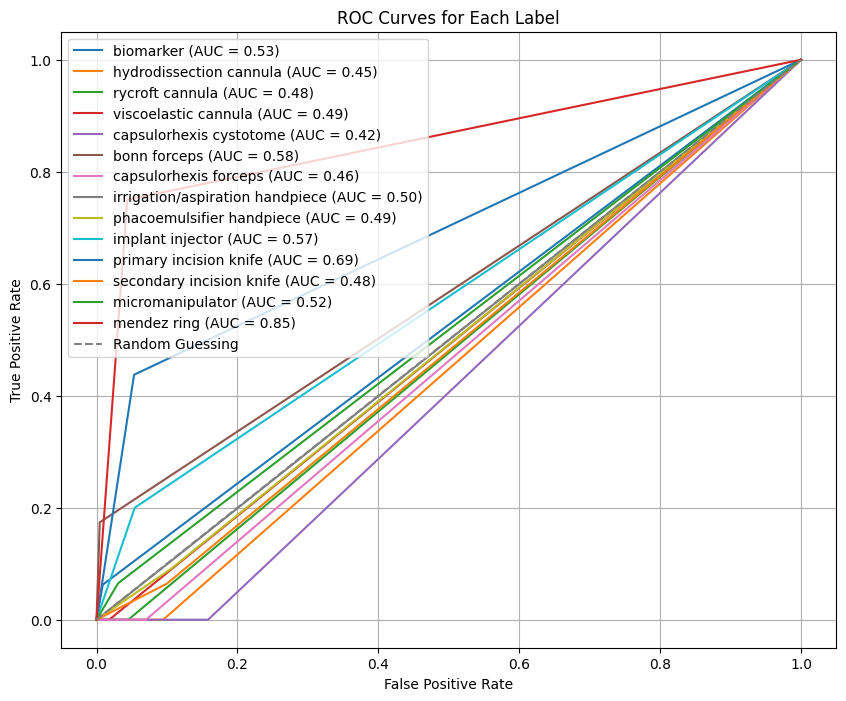

In [117]:

# Calculate the number of occurrences of 1 for each label (along axis 0)
baseline_positive_rate = np.sum(aggr_tru, axis=0)
predictions_positive_rate = np.sum(aggr_pred, axis=0)

# Define labels
labels = features
# Initialize dictionaries to store predictions and truths for each label
label_predictions = {}
label_truths = {}

# Extract predictions and truths for each label
for i, label in enumerate(labels):
    label_predictions[label] = aggr_pred[:, i]
    label_truths[label] = aggr_tru[:, i]

# Calculate precision, recall, and F1 score for each label
label_scores = {}
all_f1 = []
all_aucs = []
f1_avg = 0

# Plot ROC curves for each label
plt.figure(figsize=(10, 8))

for label in labels:
    # Calculate precision, recall, and F1 score
    precision, recall, f1_score, support = precision_recall_fscore_support(label_truths[label], label_predictions[label], labels=[1], zero_division=np.nan)
    all_f1.append(f1_score)

    # Store scores in dictionary
    label_scores[label] = {"precision": precision, "recall": recall, "f1_score": f1_score}
    print(f"Label: {label}")
    print(f"F1 Score: {label_scores[label]['f1_score']}")
    print()

    # Calculate FPR and TPR
    fpr, tpr, _ = roc_curve(label_truths[label], label_predictions[label])
    
    # Calculate AUC
    auc_score = auc(fpr, tpr)
    all_aucs.append(auc_score)
    
    # Check if AUC is not NaN before plotting
    if not np.isnan(auc_score):
        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'{label} (AUC = {auc_score:.2f})')

# Plot ROC curve for random guessing (diagonal line)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Label')
plt.legend()
plt.grid(True)
plt.show()

In [118]:
#print(len(baseline_positive_rate))
#print(len(predictions_positive_rate))
#print(baseline_positive_rate)
#print(predictions_positive_rate)

# Stack the arrays vertically and transpose
stacked_arrays = np.vstack((baseline_positive_rate, predictions_positive_rate)).T
print("Number of occurrences for each label, \n true vs predicted")

# Print the stacked arrays
for row in stacked_arrays:
    print(row)

# Print average AUC
non_nan_aucs = [auc_score for auc_score in all_aucs if not np.isnan(auc_score)]
if non_nan_aucs:
    print("Average AUC:", np.mean(non_nan_aucs))
else:
    print("No valid AUC values to calculate average.")

# Calculate the average F1 score excluding NaN values
average_f1_score = np.nanmean(all_f1)
print("Average F1 Score:", average_f1_score)

[16 19 19 18 20 23 13 27 33 20 16 31 46 12]
[ 3 21 10  4 35  5 16 27 25 16 19 23  9 19]
Number of occurrences for each label, 
 true vs predicted
[16  3]
[19 21]
[19 10]
[18  4]
[20 35]
[23  5]
[13 16]
[27 27]
[33 25]
[20 16]
[16 19]
[31 23]
[46  9]
[12 19]
Average AUC: 0.5377171174966096
Average F1 Score: 0.14225494266140934


In [ ]:
# TODO: FIX CLASS IMBALANCE A BIT; remove some micromanipulator, 2nd incision knife, phacoemulsifier handpiece and irrigation/aspiration handpiece or add more of the rest, especially Mendez Ring (will boost score) and capsulorhexis forceps

In [134]:
# Folder 30 was causing random issues..
tru, pre = queryModel(r'C:\Users\H\Desktop\VC\all_folders2\folder_1')
# Storing the results
results['folder_36'] = {'tru': tru, 'pre': pre}
# Folder 30 was causing random issues..
tru, pre = queryModel(r'C:\Users\H\Desktop\VC\all_folders2\folder_2')
# Storing the results
results['folder_37'] = {'tru': tru, 'pre': pre}
# Folder 30 was causing random issues..
tru, pre = queryModel(r'C:\Users\H\Desktop\VC\all_folders2\folder_3')
# Storing the results
results['folder_38'] = {'tru': tru, 'pre': pre}

['1. Capsulorhexis cystotome', '2. Phacoemulsifier handpiece', '3. Bonn forceps', '4. No medical tools visible', '5. No medical tools visible', '6. No medical tools visible', '7. No medical tools visible']
['1. Mendez ring, capsulorhexis cystotome', '2. Mendez ring, capsulorhexis cystotome', '3. Mendez ring, capsulorhexis cystotome', '4. Mendez ring, capsulorhexis cystotome', '5. Mendez ring, capsulorhexis cystotome', '6. No medical tools visible', '7. No medical tools visible']
['1. Capsulorhexis cystotome, Mendez ring', '2. Capsulorhexis cystotome, Mendez ring', '3. No medical tools visible', '4. No medical tools visible']


In [135]:
# Initialize empty lists for aggregation
aggregated_tru = []
aggregated_pre = []

# Iterate through each folder's results in the dictionary
for folder_result in results.values():
    tru_arrays = folder_result['tru']
    pre_arrays = folder_result['pre']
    
    # Append these arrays to the respective lists
    aggregated_tru.append(tru_arrays)
    aggregated_pre.append(pre_arrays)

# Now concatenate the lists of arrays into single aggregated arrays
aggr_tru = np.concatenate(aggregated_tru, axis=0)
aggr_pred = np.concatenate(aggregated_pre, axis=0)

Label: biomarker
F1 Score: [0.10526316]

Label: hydrodissection cannula
F1 Score: [0.]

Label: rycroft cannula
F1 Score: [0.]

Label: viscoelastic cannula
F1 Score: [0.]

Label: capsulorhexis cystotome
F1 Score: [0.]

Label: bonn forceps
F1 Score: [0.27586207]

Label: capsulorhexis forceps
F1 Score: [0.]

Label: irrigation/aspiration handpiece
F1 Score: [0.11111111]

Label: phacoemulsifier handpiece
F1 Score: [0.10169492]

Label: implant injector
F1 Score: [0.22222222]

Label: primary incision knife
F1 Score: [0.4]

Label: secondary incision knife
F1 Score: [0.07407407]

Label: micromanipulator
F1 Score: [0.10909091]

Label: mendez ring
F1 Score: [0.68085106]



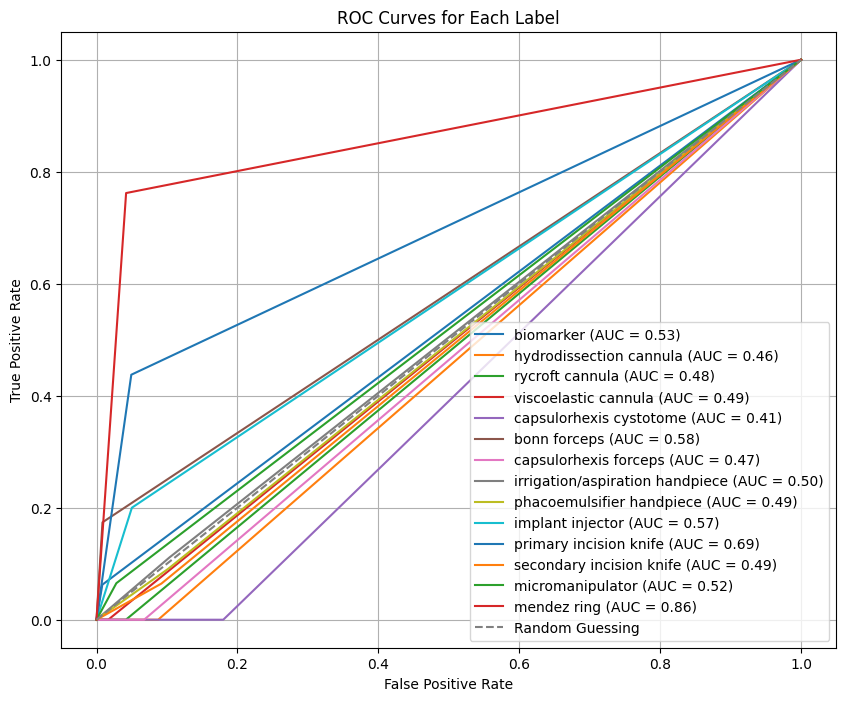

Number of occurrences for each label, 
 true vs predicted
[16  3]
[19 21]
[19 10]
[18  4]
[20 43]
[23  6]
[22 16]
[27 27]
[33 26]
[20 16]
[16 19]
[31 23]
[46  9]
[21 26]
Average AUC: 0.5389490808156039
Average F1 Score: 0.14858353731732823


In [136]:

# Calculate the number of occurrences of 1 for each label (along axis 0)
baseline_positive_rate = np.sum(aggr_tru, axis=0)
predictions_positive_rate = np.sum(aggr_pred, axis=0)

# Define labels
labels = features
# Initialize dictionaries to store predictions and truths for each label
label_predictions = {}
label_truths = {}

# Extract predictions and truths for each label
for i, label in enumerate(labels):
    label_predictions[label] = aggr_pred[:, i]
    label_truths[label] = aggr_tru[:, i]

# Calculate precision, recall, and F1 score for each label
label_scores = {}
all_f1 = []
all_aucs = []
f1_avg = 0

# Plot ROC curves for each label
plt.figure(figsize=(10, 8))

for label in labels:
    # Calculate precision, recall, and F1 score
    precision, recall, f1_score, support = precision_recall_fscore_support(label_truths[label], label_predictions[label], labels=[1], zero_division=np.nan)
    all_f1.append(f1_score)

    # Store scores in dictionary
    label_scores[label] = {"precision": precision, "recall": recall, "f1_score": f1_score}
    print(f"Label: {label}")
    print(f"F1 Score: {label_scores[label]['f1_score']}")
    print()

    # Calculate FPR and TPR
    fpr, tpr, _ = roc_curve(label_truths[label], label_predictions[label])
    
    # Calculate AUC
    auc_score = auc(fpr, tpr)
    all_aucs.append(auc_score)
    
    # Check if AUC is not NaN before plotting
    if not np.isnan(auc_score):
        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'{label} (AUC = {auc_score:.2f})')

# Plot ROC curve for random guessing (diagonal line)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Label')
plt.legend()
plt.grid(True)
plt.show()

#print(len(baseline_positive_rate))
#print(len(predictions_positive_rate))
#print(baseline_positive_rate)
#print(predictions_positive_rate)

# Stack the arrays vertically and transpose
stacked_arrays = np.vstack((baseline_positive_rate, predictions_positive_rate)).T
print("Number of occurrences for each label, \n true vs predicted")

# Print the stacked arrays
for row in stacked_arrays:
    print(row)

# Print average AUC
non_nan_aucs = [auc_score for auc_score in all_aucs if not np.isnan(auc_score)]
if non_nan_aucs:
    print("Average AUC:", np.mean(non_nan_aucs))
else:
    print("No valid AUC values to calculate average.")

# Calculate the average F1 score excluding NaN values
average_f1_score = np.nanmean(all_f1)
print("Average F1 Score:", average_f1_score)

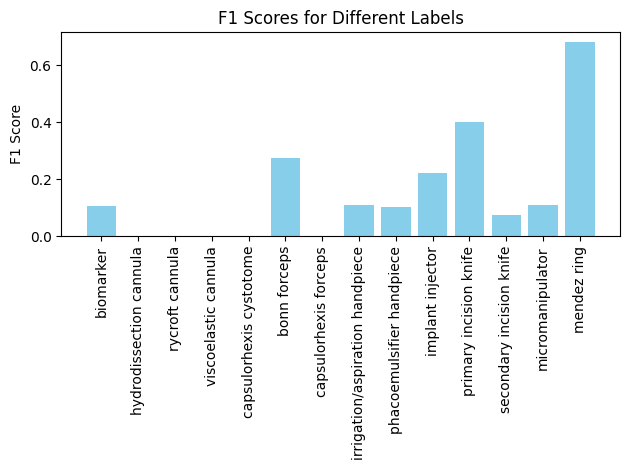

In [35]:
import matplotlib.pyplot as plt

# Define the labels and corresponding values
labels = [
    "biomarker",
    "hydrodissection cannula",
    "rycroft cannula",
    "viscoelastic cannula",
    "capsulorhexis cystotome",
    "bonn forceps",
    "capsulorhexis forceps",
    "irrigation/aspiration handpiece",
    "phacoemulsifier handpiece",
    "implant injector",
    "primary incision knife",
    "secondary incision knife",
    "micromanipulator",
    "mendez ring"
]

f1_scores = [
    0.10526316, 0, 0, 0, 0, 0.27586207, 0, 0.11111111,
    0.10169492, 0.22222222, 0.4, 0.07407407, 0.10909091, 0.68085106
]

# Plot the bar chart
#plt.figure(figsize=(10, 6))
plt.bar(range(len(labels)), f1_scores, color='skyblue')
#plt.xlabel('Labels')
plt.ylabel('F1 Score')
plt.title('F1 Scores for Different Labels')
plt.xticks(range(len(labels)), labels, rotation=90)

plt.tight_layout()
plt.show()

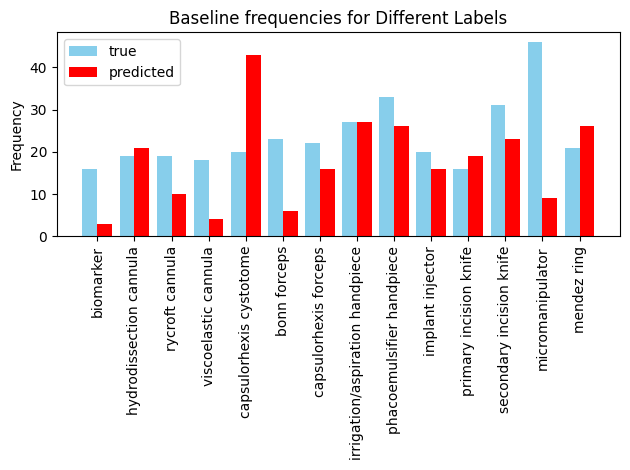

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Define the labels and corresponding values
labels = [
    "biomarker",
    "hydrodissection cannula",
    "rycroft cannula",
    "viscoelastic cannula",
    "capsulorhexis cystotome",
    "bonn forceps",
    "capsulorhexis forceps",
    "irrigation/aspiration handpiece",
    "phacoemulsifier handpiece",
    "implant injector",
    "primary incision knife",
    "secondary incision knife",
    "micromanipulator",
    "mendez ring"
]

true = [16, 19, 19, 18, 20, 23, 22, 27, 33, 20, 16, 31, 46, 21]

predicted = [3, 21, 10, 4, 43, 6, 16, 27, 26, 16, 19, 23, 9, 26]

# Plot the bar chart
#plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(labels))-0.2, true, 0.4, color='skyblue', label="true")
plt.bar(np.arange(len(labels))+0.2, predicted, 0.4, color='red', label="predicted")
#plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Baseline frequencies for Different Labels')
plt.xticks(np.arange(len(labels)), labels, rotation=90)
plt.tight_layout()
plt.legend()
plt.show()

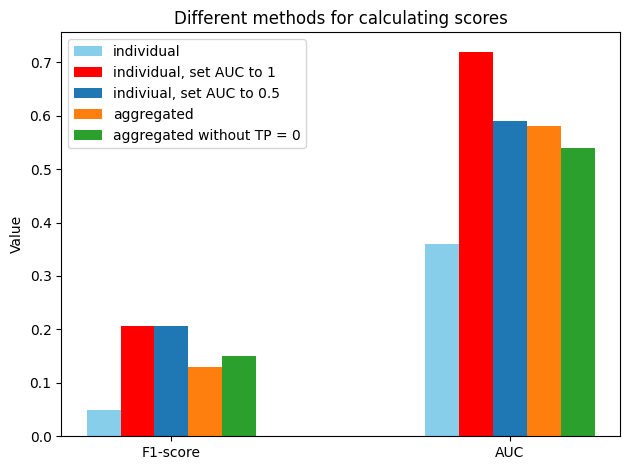

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Define the labels and corresponding values
labels = [
    "F1-score", "AUC"
]

original = [0.05, 0.36]
modified1 = [.206, 0.72]
modified2 = [0.206, 0.59]
aggregate = [0.13, 0.58]
new = [0.15, 0.54]

# Plot the bar chart
#plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(labels))-0.2, original, 0.1, color='skyblue', label="individual")
plt.bar(np.arange(len(labels))-0.1, modified1, 0.1, color='red', label="individual, set AUC to 1")
plt.bar(np.arange(len(labels)), modified2, 0.1, label="indiviual, set AUC to 0.5")
plt.bar(np.arange(len(labels))+0.1, aggregate, 0.1, label="aggregated")
plt.bar(np.arange(len(labels))+0.2, new, 0.1, label="aggregated without TP = 0")
#plt.xlabel('Labels')
plt.ylabel('Value')
plt.title('Different methods for calculating scores')
plt.xticks(np.arange(len(labels)), labels, )#rotation=90)
plt.tight_layout()
plt.legend()
plt.show()